(4)=
# 4 Test Model

For this experiment we will be selecting a portion of our prepared data to experiment with. 

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib

from math import sqrt

import IPython.display as ipy
from IPython.display import HTML
from eda_helper import sliding_windows, plot_windows

# get custom color palette and colormap
from eda_helper import get_custom_palette, get_custom_colormap


# Set fonts globally
font_name = "Derailed"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = font_name
plt.rcParams["axes.unicode_minus"] = False


# Create the file paths for reading in data and for outputting figures and tables
DATA_PATH = "../data/saville_row_east_west/"
OUTPUT_TABLES_PATH = "../output/tables/4/"
OUTPUT_FIGURES_PATH = "../output/figures/4/"

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_TABLES_PATH, exist_ok=True)
os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)

custom_palette = get_custom_palette()
custom_colormap = get_custom_colormap()

# Read in the files for exploration
east_df = pd.read_pickle(os.path.join(DATA_PATH, "east_df.pkl"))
west_df = pd.read_pickle(os.path.join(DATA_PATH, "west_df.pkl"))

In [62]:
COMPLETENESS_THRESHOLD = 0.94
WINDOW_SIZE = 12
HORIZON = 3
STRIDE = 1

(4.1)=
## 4.1 Select Modelling Technique

Outline the types of models you are considering for the project. For this case, you're considering using a Long Short-Term Memory (LSTM) neural network model for time-series prediction.

For the time-series we are going to search for and then select a full week of data. 

(4.2)=
## 4.2 Generate Test Design

Discuss how you will evaluate your model's performance. For time-series data, this could involve setting aside a portion of your dataset for validation or using techniques like time-series cross-validation.

Windowing, also known as "rolling windows" or "sliding windows," is a common method used in time series analysis and is often used with machine learning models. However, whether it's essential or not depends largely on the specific task, data characteristics, and the model being used.

Here are some points to consider:

**Sequence Learning**: Many machine learning models, especially those used for time series like Recurrent Neural Networks (RNNs) and its variants (like LSTM and GRU), require input in the form of sequences. They make predictions based on the "memory" of past data points. Windowing is a way of creating these sequences from a time series.

**Stationarity**: Windowing can help make a time series more stationary (i.e., its properties do not depend on the time at which the series is observed) by creating a series of differences between values in the window, which is a requirement for certain models.

**Feature Engineering**: Windowing can also be used for feature engineering, where you create new features based on a window of values - such as rolling averages, standard deviations, etc. This can help capture trends and seasonality in the data which can be crucial for the performance of the models.

**Reduce Noise**: A windowed average can sometimes help reduce noise and smooth out short-term fluctuations, which may be beneficial for the model.

**Temporal Dependencies**: In time-series problems, current outputs can be dependent on previous inputs or outputs (auto-regressive nature). Windowing allows capturing these temporal dependencies.

However, it's worth noting that windowing is just one of many techniques in time series analysis. Depending on the nature of your problem, other techniques may also be applicable and useful. It is always recommended to understand your data and problem thoroughly and choose the techniques that are most appropriate for your specific use case.

Aside from windowing, there are various techniques used in time series analysis, including:

* Autoregression (AR): Models the next step in the sequence as a linear function of the observations at prior time steps.
* Moving Average (MA): Models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.
* Autoregressive Moving Average (ARMA): Models the next step in the sequence as a linear function of the observations and residual errors at prior time steps.
* Autoregressive Integrated Moving Average (ARIMA): An extension of ARMA that can model a wide range of time series data.
* Seasonal Autoregressive Integrated Moving-Average (SARIMA): An extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
* Vector Autoregression (VAR): Models the next step in each time series using an AR model.
* Vector Autoregression Moving-Average (VARMA): Models the next step in each time series using an ARMA model.
* Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX): An extension of the VARMA model that also includes the modeling of exogenous variables.
* Simple Exponential Smoothing (SES): Models the next time step as an exponentially weighted linear function of observations at prior time steps.
* Holt Winter’s Exponential Smoothing (HWES): Models the next step in the sequence as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account.

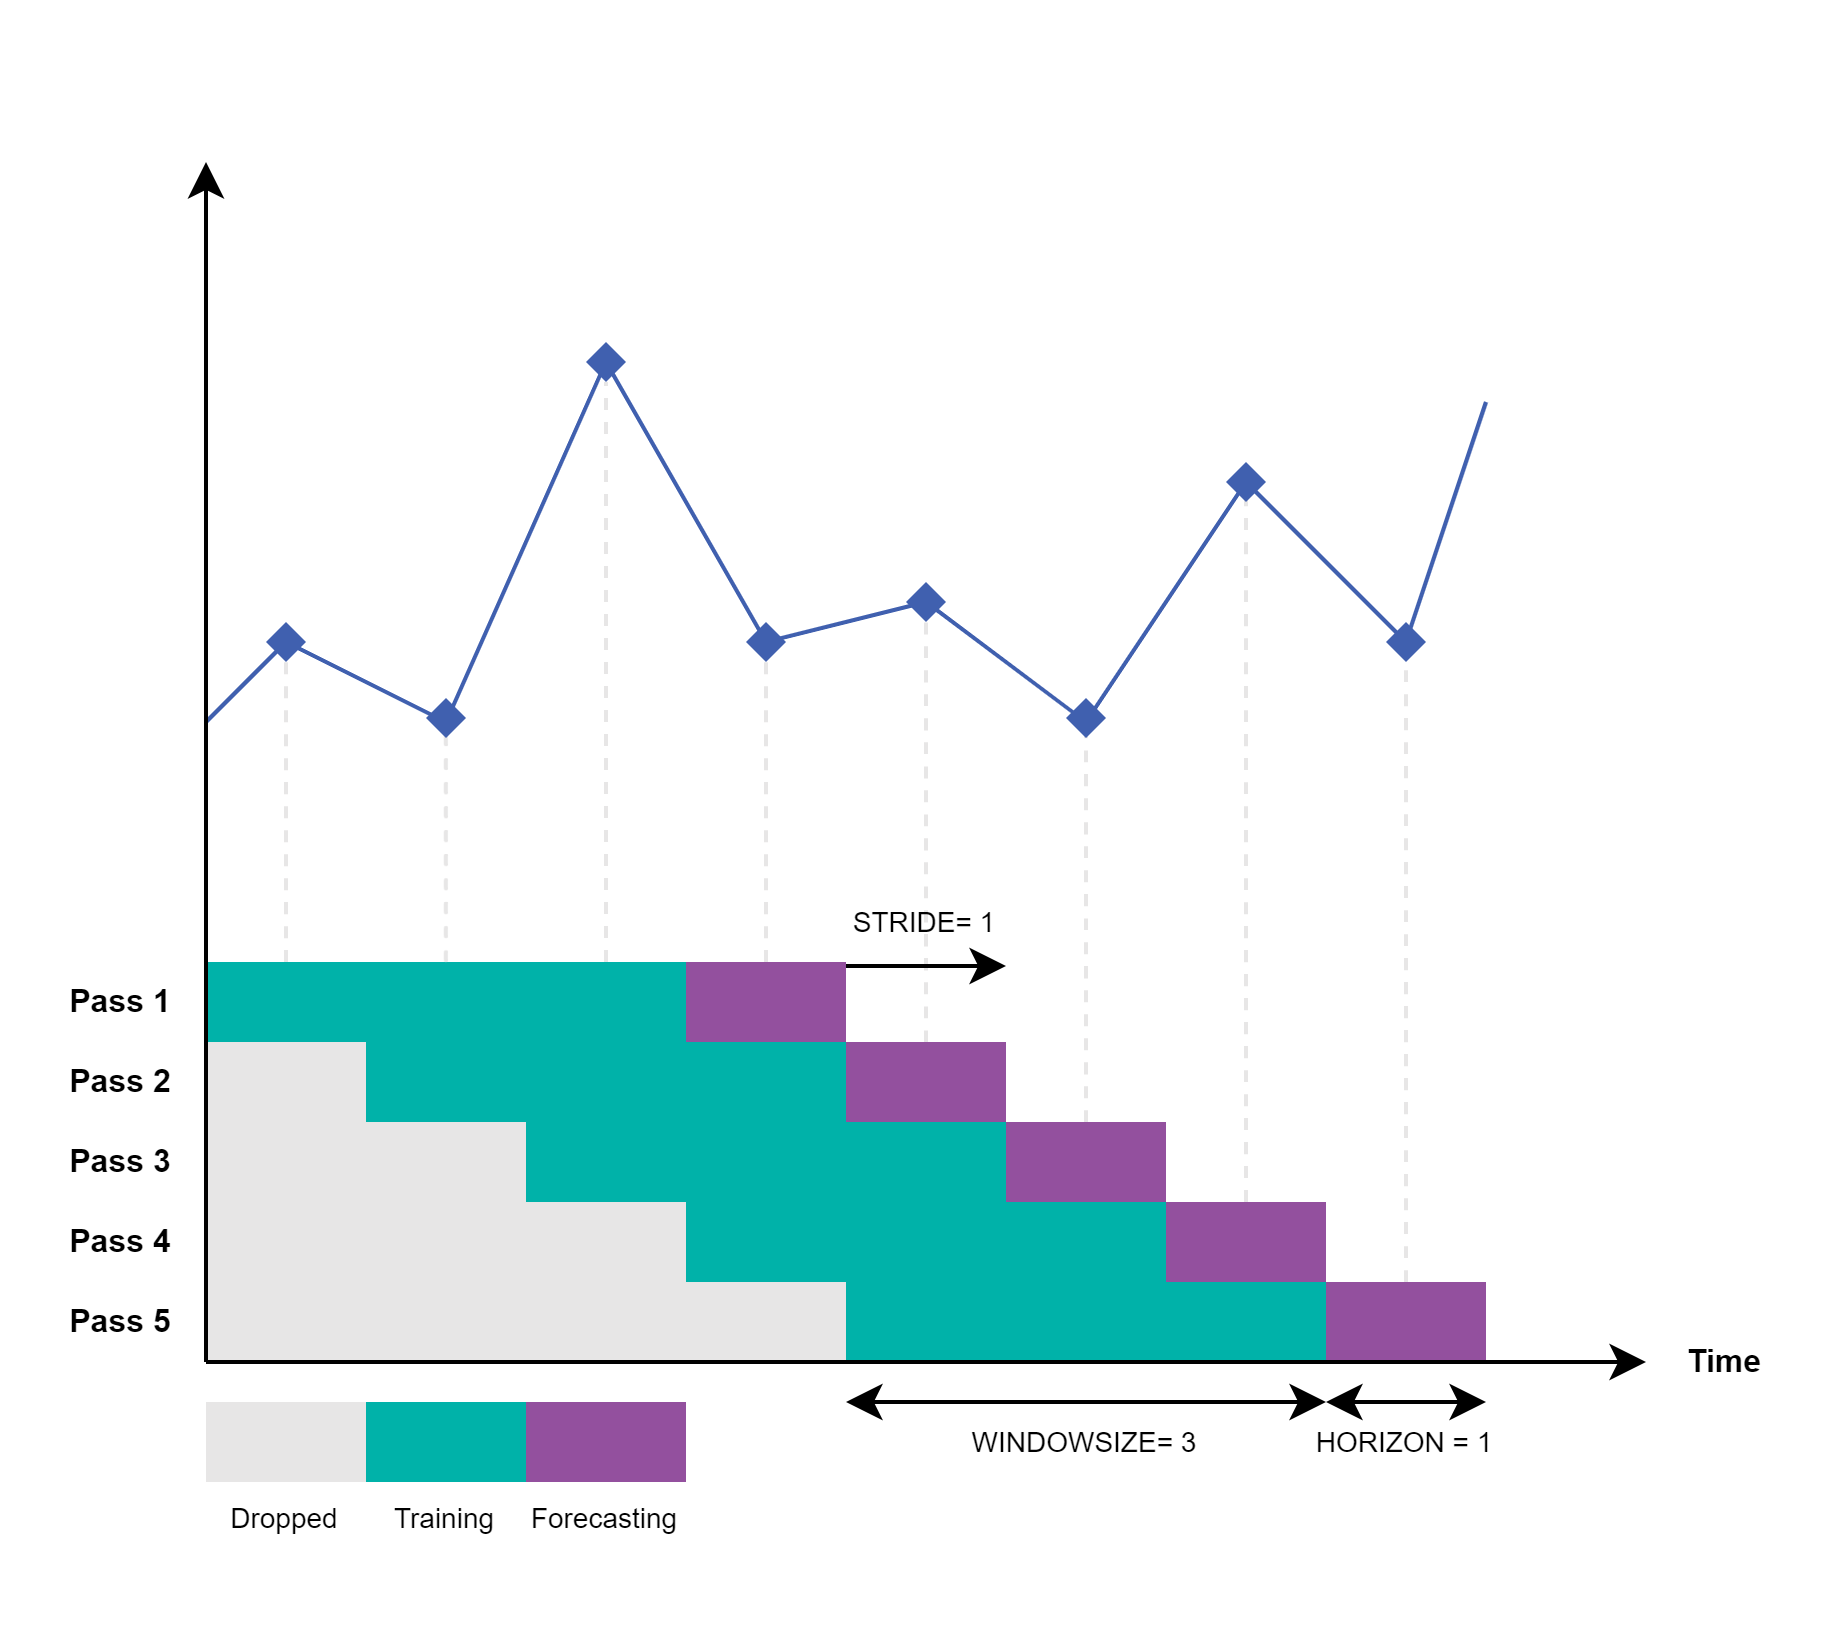

In [63]:
from IPython import display
import os

display.Image(
    os.path.join(os.getcwd(), "graphics\sliding_window_w3h3s1.png"),
    width=768,
    height=768,
)

## Model 0 - Baseline
This model takes the current value as input and returns it for the next time step, effectively predicting "no change". As our model can currently only predict a single time step into the future and the prediction will not change as window length increases. We can add an option to increase the number of predictions that the model makes however and see how performance changes as the number of time steps is increased. For single time-steps the baseline should be a reasonable estimate as the number of pedestrians generally changes slowly throughout the day. First we need to change our `pandas.core.series.Series` object into a `numpy.ndarray` object. We are dealing with a single dimensional array and the values form a time vector i.e. they are an ordered list. 

We then want to split the data into windows. In our first test run, we use a week of continuous data, and split it into windows of `WINDOWSIZE=1` and `HORIZON=1`. The baseline model will take the input and return that value as the output. We will then calculate some scores to see how far the predictions are from the labels. 

In [64]:
from eda_helper import preprocess_data

east_dict = preprocess_data(east_df, COMPLETENESS_THRESHOLD)
east_timeseries = east_dict["data"]
east_index = east_dict["index"]
east_columns = east_dict["columns"]

Removing incomplete days...
Initial number of records: 39904
Number of records in days @ 94% completeness: 32758
Proportion of records removed: 17.91%


Maximum consecutive days: 76
Starting from day number 1 in 2023


In [65]:
type(east_timeseries), east_timeseries.shape, east_timeseries.dtype

(numpy.ndarray, (7242, 11), dtype('float64'))

Inputs array shape: torch.Size([7228, 12]) | Target array shape: torch.Size([7228])
Inputs type: <class 'torch.Tensor'> | Targets type: <class 'torch.Tensor'>


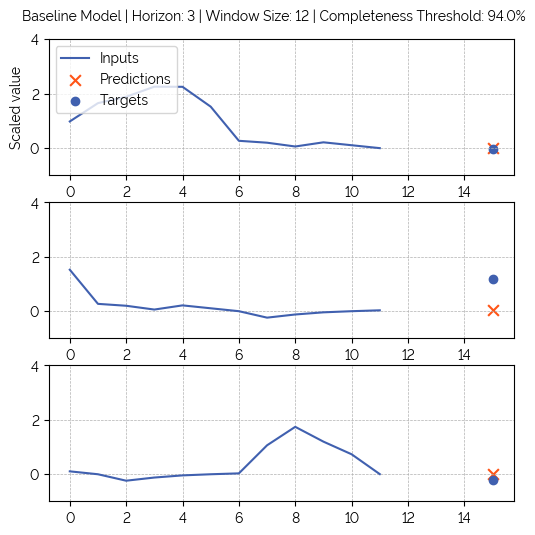

In [66]:
INPUT_INDEX = 0
TARGET_INDEX = 0
inputs, targets = sliding_windows(
    east_timeseries, WINDOW_SIZE, INPUT_INDEX, TARGET_INDEX, HORIZON, STRIDE
)
print(
    f"Inputs array shape: {inputs.squeeze().shape} | Target array shape: {targets.squeeze().shape}"
)
print(f"Inputs type: {type(inputs)} | Targets type: {type(targets)}")


# Create a baseline model that predicts the last value of the input sequence for the horizon length
class Model0(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Get the last element from each input sequence
        return x[:, -1]


baseline = Model0()

predictions = baseline(inputs.squeeze())

plot_windows(
    inputs,
    predictions.unsqueeze(dim=1),
    targets.unsqueeze(dim=1),
    HORIZON,
    num_plots=3,
    step=5,
    title=f"Baseline Model | Horizon: {HORIZON} | Window Size: {WINDOW_SIZE} | Completeness Threshold: {COMPLETENESS_THRESHOLD*100}%",
)

In [67]:
predictions[0], targets[0], inputs[0, -1]

(tensor(-0.7361, dtype=torch.float64),
 tensor(-0.7780, dtype=torch.float64),
 tensor(-0.7361, dtype=torch.float64))

In [68]:
predictions.shape, targets.shape, predictions.max(), targets.max(), predictions.min(), targets.min()

(torch.Size([7228]),
 torch.Size([7228]),
 tensor(3.6421, dtype=torch.float64),
 tensor(3.6421, dtype=torch.float64),
 tensor(-0.8804, dtype=torch.float64),
 tensor(-0.8804, dtype=torch.float64))

### Model 0 Performance

In [69]:
targets.squeeze().flatten().shape, predictions.flatten().shape

(torch.Size([7228]), torch.Size([7228]))

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Flattening predictions and targets for metric calculations
predictions_flat_np = predictions.flatten().detach().numpy()
targets_flat_np = targets.flatten().detach().numpy()

# Mean Absolute Error (MAE)
mae = mean_absolute_error(targets_flat_np, predictions_flat_np)
print(f"Mean Absolute Error (MAE): {mae}")

# Mean Squared Error (MSE)
mse = mean_squared_error(targets_flat_np, predictions_flat_np)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared (R²)
r2 = r2_score(targets_flat_np, predictions_flat_np)
print(f"R-squared (R²): {r2}")

# Create a dictionary with the metrics
metrics = {
    "Model": "Baseline",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R^2": r2,
}

performance_df = pd.DataFrame(columns=["Model", "MAE", "MSE", "RMSE", "R^2"])

# Append the dictionary to the DataFrame
metrics_df = pd.DataFrame(metrics, index=[0])
performance_df = pd.concat([performance_df, metrics_df])

# Print the DataFrame
print(performance_df.round(3))

Mean Absolute Error (MAE): 0.24139243036602964
Mean Squared Error (MSE): 0.14267684139527329
Root Mean Squared Error (RMSE): 0.37772588128863144
R-squared (R²): 0.8574741967428271
      Model    MAE    MSE   RMSE    R^2
0  Baseline  0.241  0.143  0.378  0.857


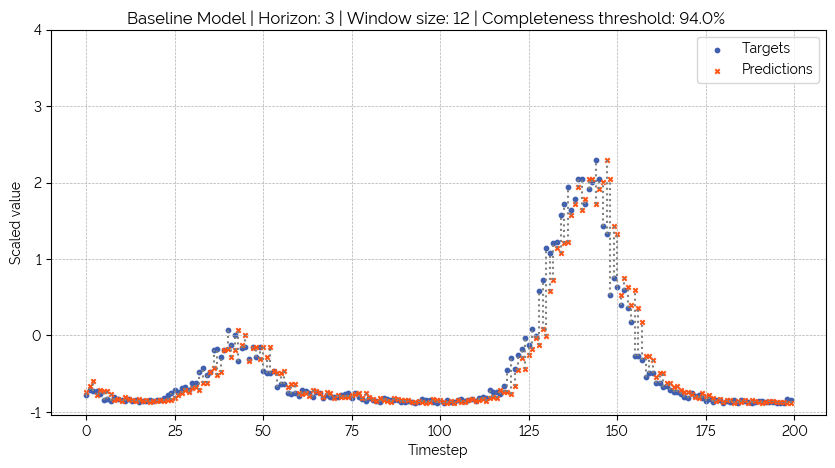

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(
    f"Baseline Model | Horizon: {HORIZON} | Window size: {WINDOW_SIZE} | Completeness threshold: {COMPLETENESS_THRESHOLD*100}%",
    y=0.92,
)

ax.scatter(
    list(range(len(targets_flat_np)))[:200],
    targets_flat_np[:200],
    label="Targets",
    s=10,
    marker="o",
    color=custom_palette[0],
)
ax.scatter(
    list(range(len(targets_flat_np)))[:200],
    predictions_flat_np[:200],
    label="Predictions",
    s=10,
    marker="x",
    color=custom_palette[1],
)

# Add vertical lines
for i in range(len(targets_flat_np))[:200]:
    ax.vlines(
        x=i,
        ymin=min(targets_flat_np[i], predictions_flat_np[i]),
        ymax=max(targets_flat_np[i], predictions_flat_np[i]),
        colors="gray",
        linestyles="dotted",
    )
ax.set_xlabel("Timestep")
ax.set_ylabel("Scaled value")
ax.set_yticks(np.arange(-1, 5, 1))
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

## Model 1: Simple LSTM
For our first LSTM model, we will use a single LSTM layer and a linear output layer. The model is only capable of providing a single time step output, so the distance we want to predict into the future depends on the frequency of data points that we feed into out from our generated windows. To begin with we attempt to predict 15 minutes into the future as this is the highest frequency of measurements we have for training. Later on we may aggregate to hourly or daily measurements to allow us to predict further into the future. 

In [72]:
class LSTMModel1(nn.Module):
    def __init__(self, *args, **kwargs) -> torch.Tensor:
        super().__init__(*args, **kwargs)
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=50, num_layers=1, batch_first=True
        )
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x[:, -1, :]  # Selecting the last output of the sequence


class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

Here we create a function for training and evaluating our data. The function saves the following results from the training loop: Window size; Epoch; Train RMSE; Test RMSE. 

In [73]:
INPUT_INDICES = 0
TARGET_INDEX = 0
BATCH_SIZE = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

east_dict = preprocess_data(east_df, COMPLETENESS_THRESHOLD)
# store the different keys of the dictionary in separate variables
east_timeseries = east_dict["data"]
east_columns = east_dict["columns"]
east_index = east_dict["index"]

# create the sliding windows
inputs, targets = sliding_windows(
    east_timeseries, WINDOW_SIZE, INPUT_INDICES, TARGET_INDEX, HORIZON
)

Removing incomplete days...
Initial number of records: 39904
Number of records in days @ 94% completeness: 32758
Proportion of records removed: 17.91%
Maximum consecutive days: 76
Starting from day number 1 in 2023


In [74]:
print(
    [
        (east_columns[i], east_timeseries[:, i].max(), east_timeseries[:, i].min())
        for i in range(len(east_columns))
    ]
)

[('value', 3.6420934722132183, -0.8803637975039135), ('newcastle_term', 1.0, 0.0), ('northumbria_term', 1.0, 0.0), ('sin_day', 1.0, -1.0), ('cos_day', 1.0, -1.0), ('sin_half_day', 1.0, -1.0), ('cos_half_day', 1.0, -1.0), ('sin_quarter', 0.9999166586547379, -0.9995462806873573), ('cos_quarter', 0.9976303053065857, -0.9996666485105112), ('sin_year', 0.9657399376548549, 0.017213356155834685), ('cos_year', 0.9998518392091162, 0.2595117970697999)]


In [75]:
# Split into train and test sets
train_size = int(len(inputs) * 0.8)  # 70% for training, 30% for testing
test_size = len(inputs) - train_size
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]

# Creating datasets
train_dataset = TimeSeriesDataset(train_inputs, train_targets)
test_dataset = TimeSeriesDataset(test_inputs, test_targets)

# Creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X, y in train_dataloader:
    print(f"Input shape: {X.shape} | Target shape: {y.shape}")
    break

Input shape: torch.Size([8, 12]) | Target shape: torch.Size([8])


In [76]:
EPOCHS = 20
device = "cpu"

In [77]:
for epoch in range(EPOCHS):
    print("Overview of the dataloader")
    print("Training")
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = (X, y)
        print(
            f"Batch: {batch} | Shape: {X.shape, y.shape} | Data type: {X.dtype, y.dtype}"
        )
        X, y = X.unsqueeze(-1).float().to(device), y.unsqueeze(-1).unsqueeze(
            -1
        ).float().to(device)
        print(
            f"Batch: {batch} | Shape: {X.shape, y.shape} | Data type: {X.dtype, y.dtype}"
        )
        if batch == 0:
            break
    print("Testing")
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = (X, y)
        print(
            f"Batch: {batch} | Shape: {X.shape, y.shape} | Data type: {X.dtype, y.dtype}"
        )
        X, y = X.unsqueeze(-1).float().to(device), y.unsqueeze(-1).unsqueeze(
            -1
        ).float().to(device)
        print(
            f"Batch: {batch} | Shape: {X.shape, y.shape} | Data type: {X.dtype, y.dtype}"
        )
        if batch == 0:
            break
    break

Overview of the dataloader
Training
Batch: 0 | Shape: (torch.Size([8, 12]), torch.Size([8])) | Data type: (torch.float64, torch.float64)
Batch: 0 | Shape: (torch.Size([8, 12, 1]), torch.Size([8, 1, 1])) | Data type: (torch.float32, torch.float32)
Testing
Batch: 0 | Shape: (torch.Size([8, 12]), torch.Size([8])) | Data type: (torch.float64, torch.float64)
Batch: 0 | Shape: (torch.Size([8, 12, 1]), torch.Size([8, 1, 1])) | Data type: (torch.float32, torch.float32)


In [78]:
model = LSTMModel1().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

train_metrics = []
test_metrics = []
torch.manual_seed(42)
for epoch in range(EPOCHS):
    train_MSE, train_RMSE = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = (X, y)
        X, y = X.unsqueeze(-1).float().to(device), y.unsqueeze(-1).unsqueeze(
            -1
        ).float().to(device)
        model.train()
        train_preds = model(X)
        loss_MSE = criterion(train_preds.unsqueeze(dim=-1), y)

        optimizer.zero_grad()
        loss_MSE.backward()
        optimizer.step()

        train_MSE += loss_MSE.item()
        train_RMSE += sqrt(loss_MSE.item())

    train_MSE /= len(train_dataloader)  # MSE per epoch
    train_RMSE /= len(train_dataloader)  # RMSE per epoch
    train_metrics.append([epoch, train_MSE, train_RMSE])

    test_MSE, test_RMSE = 0, 0
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = (X, y)
        X, y = X.unsqueeze(-1).float().to(device), y.unsqueeze(-1).unsqueeze(
            -1
        ).float().to(device)
        model.eval()
        with torch.inference_mode():
            test_preds = model(X)
            loss_MSE = criterion(test_preds.unsqueeze(dim=-1), y)

        test_MSE += loss_MSE.item()
        test_RMSE += sqrt(loss_MSE.item())

    test_MSE /= len(test_dataloader)  # MSE per epoch
    test_RMSE /= len(test_dataloader)  # RMSE per epoch
    test_metrics.append([epoch, test_MSE, test_RMSE])

    # if epoch % 10 == 9:
    print(
        f"Epoch: {epoch+1} | Train MSE: {train_MSE:.5f} | Train RMSE: {train_RMSE} | Test MSE: {test_MSE:.5f} | Test RMSE: {test_RMSE:.5f}"
    )

Epoch: 1 | Train MSE: 0.20926 | Train RMSE: 0.34878562490708115 | Test MSE: 0.10726 | Test RMSE: 0.26933
Epoch: 2 | Train MSE: 0.12748 | Train RMSE: 0.2737668297852231 | Test MSE: 0.10247 | Test RMSE: 0.26198
Epoch: 3 | Train MSE: 0.12120 | Train RMSE: 0.26628558088956483 | Test MSE: 0.09960 | Test RMSE: 0.25735
Epoch: 4 | Train MSE: 0.11669 | Train RMSE: 0.2610531045605136 | Test MSE: 0.09806 | Test RMSE: 0.25438
Epoch: 5 | Train MSE: 0.11348 | Train RMSE: 0.2572746084012797 | Test MSE: 0.09724 | Test RMSE: 0.25204
Epoch: 6 | Train MSE: 0.11123 | Train RMSE: 0.254586751176031 | Test MSE: 0.09662 | Test RMSE: 0.24989
Epoch: 7 | Train MSE: 0.10959 | Train RMSE: 0.25279055879466744 | Test MSE: 0.09632 | Test RMSE: 0.24861
Epoch: 8 | Train MSE: 0.10844 | Train RMSE: 0.25151185439697166 | Test MSE: 0.09630 | Test RMSE: 0.24772
Epoch: 9 | Train MSE: 0.10759 | Train RMSE: 0.2504350581510407 | Test MSE: 0.09631 | Test RMSE: 0.24715
Epoch: 10 | Train MSE: 0.10691 | Train RMSE: 0.24948375474193

In [79]:
test_targets[0]
predictions.shape

torch.Size([7228])

In [80]:
test_inputs.shape, test_targets.shape, predictions.shape

(torch.Size([1446, 12]), torch.Size([1446]), torch.Size([7228]))

torch.Size([1446, 12])
torch.Size([1446])
torch.Size([1446, 1])
tensor([1.6368, 1.5344, 1.6833, 1.7577, 1.5763, 1.8834, 1.4832, 0.8505, 0.6923,
        0.5713, 0.5294, 0.2270], dtype=torch.float64)


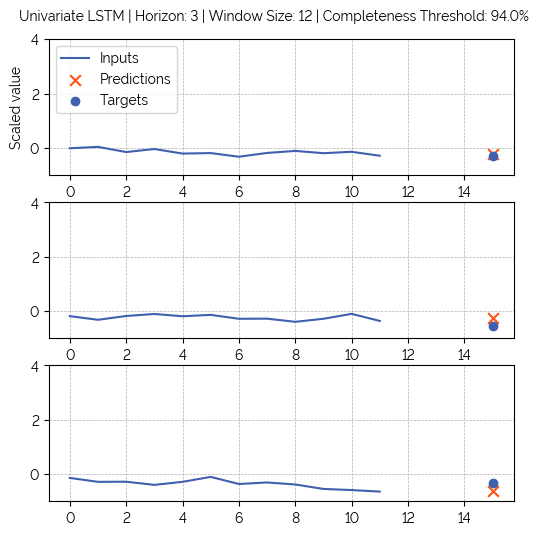

In [81]:
predictions = model(test_inputs.to(device).unsqueeze(dim=-1).float())
print(test_inputs.shape)
print(test_targets.shape)
print(predictions.shape)
print(test_inputs[0])

predictions_np = predictions.detach().numpy()
test_targets_np = test_targets.unsqueeze(dim=-1).detach().numpy()
test_inputs_np = test_inputs.detach().numpy()

plot_windows(
    test_inputs_np,
    predictions_np,
    test_targets_np,
    HORIZON,
    num_plots=3,
    step=5,
    title=f"Univariate LSTM | Horizon: {HORIZON} | Window Size: {WINDOW_SIZE} | Completeness Threshold: {COMPLETENESS_THRESHOLD*100}%",
)

In [82]:
test_targets.flatten().detach().numpy().shape, predictions.flatten().detach().numpy().shape

((1446,), (1446,))

In [83]:
# Flattening predictions and targets for metric calculations
predictions_flat_np = predictions.flatten().detach().numpy()
test_targets_flat_np = test_targets.flatten().detach().numpy()

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets_flat_np, predictions_flat_np)
print(f"Mean Absolute Error (MAE): {mae}")

# Mean Squared Error (MSE)
mse = mean_squared_error(test_targets_flat_np, predictions_flat_np)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared (R²)
r2 = r2_score(test_targets_flat_np, predictions_flat_np)
print(f"R-squared (R²): {r2}")

# Create a dictionary with the metrics
metrics = {
    "Model": "Simple LSTM",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R^2": r2,
}

performance_df.loc[1] = metrics

# Print the DataFrame
print(performance_df.round(3))

Mean Absolute Error (MAE): 0.20227696299338002
Mean Squared Error (MSE): 0.09330064245033717
Root Mean Squared Error (RMSE): 0.30545153862820396
R-squared (R²): 0.9152808555464098
         Model    MAE    MSE   RMSE    R^2
0     Baseline  0.241  0.143  0.378  0.857
1  Simple LSTM  0.202  0.093  0.305  0.915


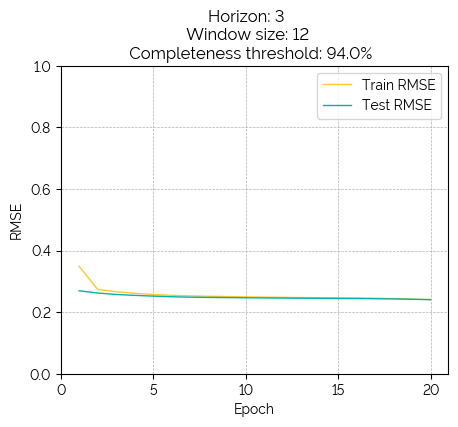

In [84]:
train_metrics_df = pd.DataFrame(train_metrics, columns=["Epoch", "MSE", "RMSE"])
test_metrics_df = pd.DataFrame(test_metrics, columns=["Epoch", "MSE", "RMSE"])

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle(
    f"Horizon: {HORIZON} \n Window size: {WINDOW_SIZE} \n Completeness threshold: {COMPLETENESS_THRESHOLD*100}%",
    y=1.02,
)
ax.plot(
    train_metrics_df["Epoch"] + 1,
    train_metrics_df["RMSE"],
    label="Train RMSE",
    color=custom_palette[2],
    linewidth=1,
)
ax.plot(
    test_metrics_df["Epoch"] + 1,
    test_metrics_df["RMSE"],
    label="Test RMSE",
    color=custom_palette[3],
    linewidth=1,
)
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

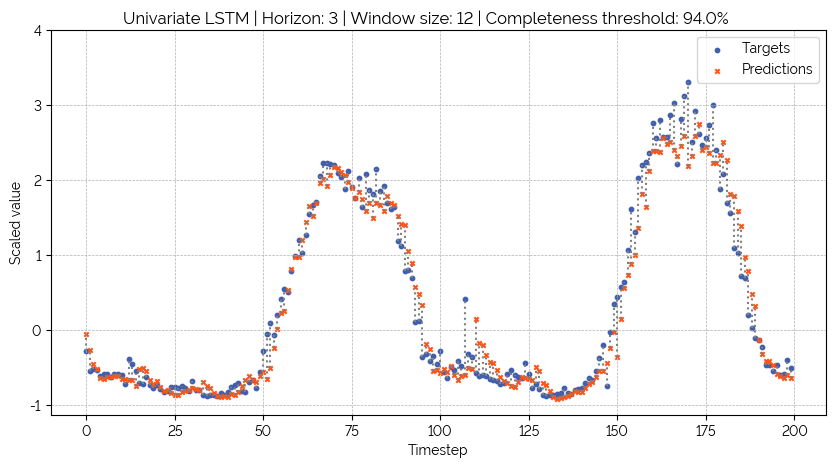

In [85]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(
    f"Univariate LSTM | Horizon: {HORIZON} | Window size: {WINDOW_SIZE} | Completeness threshold: {COMPLETENESS_THRESHOLD*100}%",
    y=0.92,
)

ax.scatter(
    list(range(len(test_targets)))[:200],
    test_targets.detach().numpy().flatten()[:200],
    label="Targets",
    s=10,
    marker="o",
    color=custom_palette[0],
)
ax.scatter(
    list(range(len(test_targets)))[:200],
    predictions.detach().numpy().flatten()[:200],
    label="Predictions",
    s=10,
    marker="x",
    color=custom_palette[1],
)

# Add vertical lines
for i in range(len(test_targets_np))[:200]:
    ax.vlines(
        x=i,
        ymin=min(test_targets_np[i], predictions_np.squeeze()[i]),
        ymax=max(test_targets_np[i], predictions_np.squeeze()[i]),
        colors="gray",
        linestyles="dotted",
    )
ax.set_xlabel("Timestep")
ax.set_ylabel("Scaled value")
ax.set_yticks(np.arange(-1, 5, 1))
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

In [86]:
# Prediction and Error Calculation
model.eval()
with torch.no_grad():
    predictions = model(inputs.to(device).unsqueeze(dim=-1).float())
errors = (predictions.squeeze(dim=-1) - targets.squeeze(dim=-1)).abs().numpy()

# Threshold Determination
ERROR_STD = 4
threshold = errors.mean() + ERROR_STD * errors.std()

# Anomaly Detection
anomalies = errors > threshold

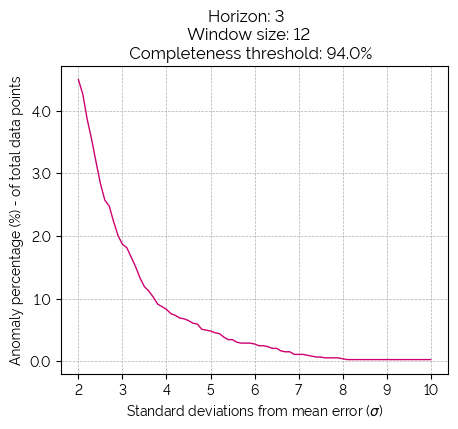

In [87]:
totals = []
percentages = []
standard_deviations = list(np.arange(start=2, stop=10.1, step=0.1))
for i in standard_deviations:
    threshold_i = errors.mean() + i * errors.std()
    anomalies_i = errors > threshold_i
    total_anomalies_i = np.sum(anomalies_i)
    anomaly_percentage_i = (total_anomalies_i / len(targets)) * 100
    totals.append(total_anomalies_i)
    percentages.append(anomaly_percentage_i)

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle(
    f"Horizon: {HORIZON} \n Window size: {WINDOW_SIZE} \n Completeness threshold: {COMPLETENESS_THRESHOLD*100}%",
    y=1.02,
)
ax.plot(standard_deviations, percentages, color=custom_palette[7], linewidth=1)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_xlabel("Standard deviations from mean error ($\sigma$)")
ax.set_ylabel("Anomaly percentage (%) - of total data points")
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))

In [88]:
errors.shape, anomalies.shape

((7228,), (7228,))

In [89]:
inputs.unsqueeze(dim=-1).float().shape, predictions.squeeze(dim=-1).shape, targts.shapee

(torch.Size([7228, 12, 1]), torch.Size([7228]), torch.Size([7228]))

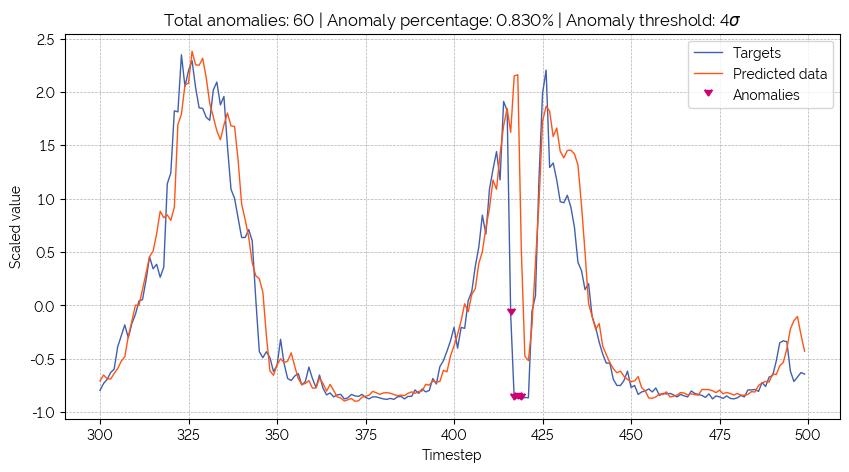

In [90]:
# Count total anomalies
total_anomalies = np.sum(anomalies)
# Create time vector
time = np.arange(len(inputs))
# Get the anomaly times and values
anomaly_times = time[anomalies]
anomaly_values = targets[anomalies]
anomalies_in_range = (anomaly_times > 300) & (anomaly_times < 500)
anomaly_times_in_range = anomaly_times[anomalies_in_range]
anomalies_values_in_range = anomaly_values[anomalies_in_range]
plt.figure(figsize=(10, 5))
# Plot the time series
plt.plot(
    time[300:500],
    targets[300:500],
    label="Targets",
    linewidth=1,
    color=custom_palette[0],
)
plt.plot(
    time[300:500],
    predictions.numpy()[300:500],
    linewidth=1,
    label="Predicted data",
    color=custom_palette[1],
)
# Mark the anomalies
plt.scatter(
    anomaly_times_in_range,
    anomalies_values_in_range,
    label="Anomalies",
    color=custom_palette[7],
    marker=7,
    s=30,
    zorder=3,
)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylabel("Scaled value")
plt.xlabel("Timestep")
plt.title(
    f"Total anomalies: {total_anomalies} | Anomaly percentage: {(total_anomalies / len(targets))*100:.3f}% | Anomaly threshold: {ERROR_STD}$\sigma$"
)
plt.legend()
plt.show()

(4.3)=
## 4.3 Build Model

This section would discuss the specifics of the model architecture you decided on (the LSTM, in your case). Discuss your choice of parameters, like the number of layers, hidden units, input size, etc., and why you chose them. Also, describe the software and libraries used to create the model.

(4.4)=
## 4.4 Model Assumptions

Discuss any assumptions that your model makes. For example, LSTMs assume that future values can be predicted from past values, which may not always be accurate.

(4.5)=
## 4.5 Model Training

Document the process of training your model. Include any details about the learning rate, loss function, optimizer, number of epochs, etc. Also, include any details about the training process itself, like the hardware used, how long it took, any challenges you encountered, etc.

(4.6)=
## 4.6 Model Evaluation

Detail the performance of your model on the validation dataset. Discuss any metrics you used to evaluate the model's performance (like MSE, MAE, etc.), and why you chose these metrics. Also, discuss how the model performed with respect to these metrics, and any steps you took to improve its performance (like tuning hyperparameters, adjusting the model architecture, etc.).

(4.7)=
## 4.7 Model Interpretation and Visualisation

Interpret the predictions made by your model, and discuss any insights they may provide. If possible, visualise these predictions using appropriate plots.

(4.8)=
## 4.8 Model Validation

Discuss any additional steps you took to validate your model's performance. This could include applying it to an independent test set, checking its performance against a simpler model, or verifying its results with a domain expert.

(4.9)=
## 4.9 Challenges and Learnings

Discuss any challenges faced during the model building and evaluation process and how you overcame them. Mention what you learned during this process.

(4.10)=
## 4.10 Conclusion and Next Steps...

Summarize your findings, the performance of your model, and potential next steps. This could include ideas for improving the model's performance, plans for deploying the model, or other tasks that could build upon your current work.